In [1]:
%matplotlib inline

In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [3]:
class Body(object):
    def __init__(self, mass, x, y):
        self.mass = mass
        self.x = x
        self.y = y
        self.a = [0,0]
        self.v = [0,0]
        
    '''
    Psuedocode from: http://arborjs.org/docs/barnes-hut
    
    1. If the current node is an external node (and it is not body b), calculate the 
       force exerted by the current node on b, and add this amount to b’s net force.
    
    2. Otherwise, calculate the ratio s/d. If s/d < θ, treat this internal node as a 
       single body, and calculate the force it exerts on body b, and add this amount to 
       b’s net force.
    
    3. Otherwise, run the procedure recursively on each of the current node’s children.
    '''
    def compute_acceleration(self, tree, g, theta):
        dx = tree.x_cm - self.x
        dy = tree.y_cm - self.y
        r2 = dx*dx + dy*dy
        r = math.sqrt(r2)
        if (tree.b and tree.children == [] and r != 0) or \
           (tree.num_bodies != 0 and tree.size < r * theta):
            mag = g * tree.total_mass
            self.a[0] += mag * dx / r2
            self.a[1] += mag * dy / r2
        else: 
            for ch in tree.children:
                self.compute_acceleration(ch, g, theta)
                        
    def compute_velocity(self, time_step=1):
        if self.a:
            self.v = [0,0]
            self.v[0] += self.a[0] * time_step
            self.v[1] += self.a[1] * time_step

In [4]:
class QuadTree(object):
    def __init__(self, x_min, x_max, y_min, y_max):
        self.b = None
        self.num_bodies = 0
        self.total_mass = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.x_mid = (self.x_min + self.x_max) / 2
        self.y_mid = (self.y_min + self.y_max) / 2
        self.size = x_max - x_min
        self.x_cm = 0
        self.y_cm = 0
        self.children = []
        
    def get_quadrant_index(self, b):
        if b.y > self.y_mid:
            if b.x > self.x_mid:
                return 0 # Q1
            else: 
                return 1 # Q2
        else:
            if b.x < self.x_mid:
                return 2 # Q3
            else:
                return 3 # Q4
    
    def subdivide(self):
        self.children = [QuadTree(self.x_mid, self.x_max, self.y_mid, self.y_max),
                         QuadTree(self.x_min, self.x_mid, self.y_mid, self.y_max),
                         QuadTree(self.x_min, self.x_mid, self.y_min, self.y_mid),
                         QuadTree(self.x_mid, self.x_max, self.y_min, self.y_mid)]
    
    def insert(self, b):
        b_idx = self.get_quadrant_index(b)
        if self.num_bodies == 0:
            self.b = b
        elif self.children:
            self.children[b_idx].insert(b)
        else:
            self.subdivide()
            c_idx = self.get_quadrant_index(self.b)
            self.children[c_idx].insert(self.b)
            self.b = None
            self.children[b_idx].insert(b)
        self.num_bodies += 1 
    
    def compute_cm(self):
        if self.b:
            self.total_mass = self.b.mass
            self.x_cm = self.b.x
            self.y_cm = self.b.y
        else:
            for ch in self.children:
                ch.compute_cm()
                self.total_mass += ch.total_mass
            for ch in self.children:
                weight = ch.total_mass / self.total_mass
                self.x_cm += ch.x_cm * weight
                self.y_cm += ch.y_cm * weight

In [5]:
size = 2000
G_CONST = 1
THOLD = 0.5
bodies = []

def create_bodies(num_bodies=100):
    for i in range(num_bodies):
        bodies.append(Body(random.uniform(1,500), \
                           random.uniform(-size, size), \
                           random.uniform(-size, size)))
    return bodies

def build_tree():
    root = QuadTree(-size, size, -size, size)
    for b in bodies: 
        root.insert(b)
    root.compute_cm()
    for b in bodies:
        b.compute_acceleration(root, g=G_CONST, theta=THOLD)
        b.compute_velocity()
    return root

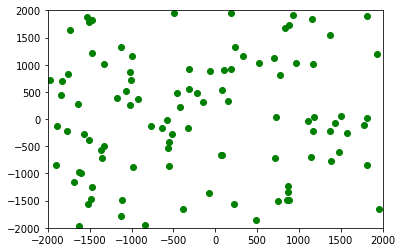

In [6]:
from IPython.display import HTML

create_bodies()
fig = plt.figure()
ax = fig.add_subplot(111)

def animate(i):
    x = [b.x for b in bodies]
    y = [b.y for b in bodies]
    build_tree()
    for b in bodies:
        b.x += b.v[0]
        b.y += b.v[1]
        b.a = [0,0]
        b.v = [0,0]
    ax.clear()
    ax.set_xlim(-size,size)
    ax.set_ylim(-size,size)
    ax.autoscale(enable=False, axis='both', tight=None)
    ax.plot(x,y,'go')
    
anim = animation.FuncAnimation(fig, animate, interval=1000)

In [7]:
plt.rcParams["animation.html"] = "jshtml"
HTML(anim.to_jshtml())